In [8]:
from src.load_data import create_data_block

import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from typing import Iterator, Union, Iterable
from more_itertools import flatten, unique_everseen
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import numpy as np
from copy import deepcopy
from torch_geometric.loader import DataLoader

In [9]:
from pytorch_lightning.utilities.warnings import PossibleUserWarning
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=PossibleUserWarning)

In [10]:
OUTPUT_DATA = "../../out_data/"
INPUT_DATA = "../../input_data/"

In [11]:
data_block = create_data_block(INPUT_DATA, OUTPUT_DATA, debug = True)

Cantidad de imágenes a procesar: 57.5
Diario: {}
Archivo: ../../input_data/La Nación 1985-05-04 Un clima cada....json | Segmento: Diario  | Estado ERROR no key/value:'bounding_box'!
Archivo: ../../input_data/La Nación 1985-05-04 Un clima cada....json | Segmento: Fecha  | Estado ERROR no key/value:'bounding_box'!
Diario: {'texto': 'Clarín', 'bounding_box': {'x': 1072, 'y': 1395, 'width': 69, 'height': 29}}
Diario: {}
Archivo: ../../input_data/Ambito financiero 1987-12-04 Reacción en cadena por el caso Astiz.json | Segmento: Diario  | Estado ERROR no key/value:'bounding_box'!
Diario: {}
Archivo: ../../input_data/La voz 1985-08-05 Sucedió.json | Segmento: Diario  | Estado ERROR no key/value:'bounding_box'!
Archivo: ../../input_data/La voz 1985-08-05 Sucedió.json | Segmento: Fecha  | Estado ERROR no key/value:'bounding_box'!
Diario: {'texto': 'TIEMPO ARGENTINO', 'bounding_box': {'x': 184, 'y': 66, 'width': 458, 'height': 41}}
Diario: {'texto': 'A fondo', 'bounding_box': {'x': 1308, 'y': 20

In [12]:
data_block[0]['token_boxes'][0].keys()

dict_keys(['id', 'top', 'left', 'box', 'box_polygon', 'box_area', 'box_height', 'box_width', 'x_position', 'y_position', 'text', 'n_line', 'n_token', 'mode_normalized_height', 'x_position_normalized', 'y_position_normalized', 'box_area_normalized', 'caps_words_ratio', 'is_date', 'number_presence', 'is_capitalized', 'width_category', 'height_category', 'label'])

In [13]:
train = data_block[:35]
val = data_block[35:42]
test = data_block[42:]
print(f'Train: {len(train)} \nVal: {len(val)}\nTest: {len(test)}')

Train: 35 
Val: 7
Test: 8


In [14]:
train[0]['token_boxes'][0].keys()

dict_keys(['id', 'top', 'left', 'box', 'box_polygon', 'box_area', 'box_height', 'box_width', 'x_position', 'y_position', 'text', 'n_line', 'n_token', 'mode_normalized_height', 'x_position_normalized', 'y_position_normalized', 'box_area_normalized', 'caps_words_ratio', 'is_date', 'number_presence', 'is_capitalized', 'width_category', 'height_category', 'label'])

In [15]:
train[0]['token_boxes'][0]

{'id': 'TGEgTmFjacOzbiAxOTg1LTA1LTA0IFVuIGNsaW1hIGNhZGEuLi4udGlmLTE=',
 'top': 17,
 'left': 39,
 'box': (39, 17, 819, 148),
 'box_polygon': <POLYGON ((819 17, 819 148, 39 148, 39 17, 819 17))>,
 'box_area': 663,
 'box_height': 131,
 'box_width': 780,
 'x_position': 39,
 'y_position': 17,
 'text': 'El análisis de la sesión de ayer',
 'n_line': 1,
 'n_token': 1,
 'mode_normalized_height': 3.5405405405405403,
 'x_position_normalized': 0.01911764705882353,
 'y_position_normalized': 0.009129967776584319,
 'box_area_normalized': 0.00017454350161117077,
 'caps_words_ratio': 0.14285714285714285,
 'is_date': False,
 'number_presence': False,
 'is_capitalized': True,
 'width_category': 0.4,
 'height_category': 0.7142857142857143,
 'label': 'Volanta'}

In [16]:
NODE_FEATURES = [
    "n_line",
    "x_position_normalized",
    "y_position_normalized",
    "box_area_normalized",
    "caps_words_ratio",
    "is_date",
    "number_presence",
    "is_capitalized",
    "width_category",
    "height_category"
]

def get_node_features(token_box: dict):
    node_features = [
        v if isinstance(v, Iterable) else [v]
        for k, v in token_box.items()
        if k in NODE_FEATURES
    ]

    assert len(NODE_FEATURES) == len(node_features), (
        "mismatch in the number of node features ",
        f"expected => {len(NODE_FEATURES)} ",
        f"current  => {len(node_features)}",
    )

    node_features = list(flatten(node_features))
    return node_features


def get_labels(datablock) -> Iterator[str]:
    labels = (
        (token["label"] for token in data_item["token_boxes"])
        for data_item in datablock
    )

    labels = flatten(labels)
    return labels


def set_label_map(datablock):
    labels = unique_everseen(get_labels(datablock))
    
    label_map = {
        label : idx
        for idx, label in enumerate(labels)
    }

    inv_label_map = {v: k for k, v in label_map.items()}
    
    return label_map, inv_label_map


def get_doc_graph(data_item, label_map) -> nx.DiGraph:
    data_map = {
        token_box["id"]: {
            "node_features": get_node_features(token_box),
            "label": label_map[token_box["label"]],
        }
        for token_box in data_item["token_boxes"]
    }

    doc_graph = data_item["doc_graph"]
    node_attributes = {
        node: {
            "x": data_map[node]["node_features"],
            "y": data_map[node]["label"],
        }
        for node in doc_graph.nodes
    }

    nx.set_node_attributes(doc_graph, node_attributes)
    return doc_graph

def get_pg_graph(doc_graph: nx.DiGraph) -> Data:
    pg_graph = from_networkx(doc_graph)
    pg_graph.x = pg_graph.x.float()
    pg_graph.y = pg_graph.y.long()
    return pg_graph

def get_pg_graphs(data_block, label_map) -> list[Data]:
    doc_graphs = [get_doc_graph(data_item,label_map) for data_item in data_block]
    pg_graph = [get_pg_graph(doc_graph) for doc_graph in doc_graphs]

    return pg_graph

In [17]:
label_map, inv_label_map = set_label_map(train)

pg_graph_train = get_pg_graphs(train, label_map)
pg_graph_val = get_pg_graphs(val, label_map)
pg_graph_test = get_pg_graphs(test, label_map)

n_features = pg_graph_train[0].x.shape[1]
n_classes = len(label_map)

hidden_channels = 512
batch_size = 32
learning_rate = 0.0001
max_epochs = 5000

train_monitor = "loss"
es_patience = 100

In [18]:
MONITOR_MAP = {
    "f1":  {
        "monitor": "val_f1",
        "mode": "max",
    },
    "loss":  {
        "monitor": "val_loss",
        "mode": "min",
    }
}

monitor = MONITOR_MAP[train_monitor]["monitor"]
mode = MONITOR_MAP[train_monitor]["mode"]

early_stop_callback = EarlyStopping(
    monitor=monitor,
    mode=mode,
    min_delta=0.00,
    patience= es_patience,
    verbose=False,
)

In [19]:
train_loader = DataLoader(
    pg_graph_train, batch_size=batch_size, shuffle=False, num_workers = 16
)

val_loader = DataLoader(
    pg_graph_val, batch_size=batch_size, shuffle=False, num_workers = 16
)

test_loader = DataLoader(
    pg_graph_test, batch_size=batch_size, shuffle=False, num_workers = 16
)

In [20]:
from torch import nn
from torch_geometric.nn import SAGEConv
from torch.nn import CrossEntropyLoss
from torchmetrics import F1Score
from torch.optim import Adam

from pytorch_lightning import LightningModule
import torch
from torch.optim import Optimizer

class Model(LightningModule):
    def __init__(
        self,
        train_loader: DataLoader,
        val_loader: DataLoader,
        hidden_channels: int,
        n_features: int,
        n_classes: int,
    ):
        super().__init__()

        self.train_loader = train_loader
        self.val_loader = val_loader

        self.lin1 = nn.Linear(512, n_features // 2)
        self.sig1 = nn.Sigmoid()

        self.sage_conv1 = SAGEConv(
            n_features,
            hidden_channels,
            aggr="mean",
        )

        self.sage_conv2 = SAGEConv(hidden_channels, n_classes, aggr="mean")

        self.ce_loss = CrossEntropyLoss()
        self.f1 = F1Score('multiclass', num_classes = n_classes, top_k=1, average="macro")

    
    def forward(
        self,
        x: torch.Tensor,
        edge_index: torch.Tensor,
    ) -> torch.Tensor:

        x = self.sage_conv1(x, edge_index)
        x = x.relu()

        x = self.sage_conv2(x, edge_index)
        return x

    def training_step(
        self, batch: torch.Tensor, batch_index: torch.Tensor
    ) -> torch.Tensor:

        x, edge_index = (
            batch.x,
            batch.edge_index,
        )

        x_out = self.forward(x, edge_index)
        loss = self.ce_loss(x_out, batch.y)

        preds = x_out.argmax(dim=1)
        self.f1(preds, batch.y)

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_f1", self.f1, prog_bar=True)

        return loss

    def validation_step(self, batch: torch.Tensor, batch_idx: torch.Tensor):
        """
        When the validation_step() is called,
        the model has been put in eval mode
        and PyTorch gradients have been disabled.
        At the end of validation, the model goes back to training mode
        and gradients are enabled.
        """

        x, edge_index = (
            batch.x,
            batch.edge_index,
        )

        x_out = self.forward(x,edge_index)
        loss = self.ce_loss(x_out, batch.y)

        preds = x_out.argmax(dim=1)
        self.f1(preds, batch.y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_f1", self.f1, prog_bar=True)

    def predict_step(
        self, batch: torch.Tensor, batch_idx: torch.Tensor
    ) -> list:

        x, edge_index = (
            batch.x,
            batch.edge_index,
        )
        pred = self(x, edge_index)

        pred = pred.softmax(dim=1)
        confidences = pred.max(dim=1)
        pred = pred.argmax(dim=1)

        return pred, confidences

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def configure_optimizers(self) -> Optimizer:
        optimizer = Adam(self.parameters(), lr=learning_rate)
        return optimizer

In [21]:
model = Model(
    train_loader, 
    val_loader,
    hidden_channels= hidden_channels,
    n_features= n_features,
    n_classes= n_classes,
)

In [22]:
trainer = Trainer(
    max_epochs= max_epochs,
    callbacks=[
        early_stop_callback,
    ]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model)

Missing logger folder: /home/damian/Documents/recordar_ia/notebooks/04_train/lightning_logs

  | Name       | Type              | Params
-------------------------------------------------
0 | lin1       | Linear            | 2.6 K 
1 | sig1       | Sigmoid           | 0     
2 | sage_conv1 | SAGEConv          | 10.8 K
3 | sage_conv2 | SAGEConv          | 12.3 K
4 | ce_loss    | CrossEntropyLoss  | 0     
5 | f1         | MulticlassF1Score | 0     
-------------------------------------------------
25.6 K    Trainable params
0         Non-trainable params
25.6 K    Total params
0.102     Total estimated model params size (MB)


Epoch 0: 100%|█| 2/2 [00:00<00:00,  6.47it/s, v_num=0, train_loss=3.590, train_f1=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                  | 0/1 [00:00<?, ?it/s]
Epoch 0: 100%|█| 2/2 [00:00<00:00,  3.16it/s, v_num=0, train_loss=3.590, train_f1=0.00
Epoch 1: 100%|█| 2/2 [00:00<00:00,  4.88it/s, v_num=0, train_loss=2.500, train_f1=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                  | 0/1 [00:00<?, ?it/s]
Epoch 1: 100%|█| 2/2 [00:00<00:00,  2.82it/s, v_num=0, train_loss=2.500, train_f1=0.00
Epoch 2: 100%|█| 2/2 [00:00<00:00,  5.01it/s, v_num=0, train_loss=1.580, train_f1=0.04
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                  | 0/1 [00:00<?, ?it/s]
Epoch 2: 100%|█| 2/2 [00:00<00:00,  2.70it/s, v_num=0, train_loss=1.580, train_f1=0.04
Epoch 3: 100%|█| 2/2 [00:00<00:00,  4.79it/s, v_num=0, train_loss=1.100, train_f1=0.07
Validation: 0it [00:00, ?it/s]
Valida

## Predict

In [24]:
def data_item_predict(data_item, pred_map: dict):

    data_item = deepcopy(data_item)
    data_item["token_boxes"] = [
        token_box | pred_map[token_box["id"]]
        for token_box in data_item["token_boxes"]
    ]
    return data_item

def predict(data_block, label_map, inv_label_map):
    pg_graphs = get_pg_graphs(data_block, label_map)

    loader = DataLoader(
        pg_graphs, batch_size=5, shuffle=False
    )

    pred_tuples = trainer.predict(model, loader)
    preds = [pred[0].cpu().numpy() for pred in pred_tuples]
    confidences = [pred[1][0].cpu().numpy() for pred in pred_tuples]

    preds = np.hstack(preds)
    confidences = np.hstack(confidences)

    pred_labels = (inv_label_map[label_idx] for label_idx in preds)
    node_ids = (
        (token_box["id"] for token_box in data["token_boxes"])
        for data in data_block
    )

    node_ids = flatten(node_ids)
    pred_map = {
        idx: {"pred_label": pred_label, "cls_conf": conf}
        for idx, pred_label, conf in zip(
            node_ids, pred_labels, confidences
        )
    }

    data_block = [
        data_item_predict(data_item, pred_map)
        for data_item in data_block
    ]

    return data_block

In [25]:
predict_data_block = predict(test, label_map, inv_label_map)

Predicting DataLoader 0: 100%|█████████████████████████| 2/2 [00:00<00:00, 180.21it/s]


In [26]:
y_true = []
y_pred = []
for data_item in predict_data_block:
    for token in data_item['token_boxes']:
        y_true.append(token['label'])
        y_pred.append(token['pred_label'])
        
len(y_true), len(y_pred)

(833, 833)

In [27]:
y_true = [str(i) for i in y_true]
y_pred = [str(i) for i in y_pred]

In [28]:
for label in label_map.keys():
    print(f'{label} : true {len([i for i in y_true if i == label])} || pred {len([i for i in y_pred if i == label])}')

Volanta : true 5 || pred 1
Título : true 14 || pred 13
Cuerpo : true 737 || pred 762
Indefinido : true 24 || pred 45
Fotografía : true 27 || pred 2
Diario : true 5 || pred 4
Fecha : true 2 || pred 2
Firma : true 5 || pred 0
Copete : true 5 || pred 1
Destacado : true 3 || pred 3
Página : true 1 || pred 0
Epígrafe : true 5 || pred 0


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix


def show_metrics(
    y_true,
    y_pred,
    inv_label_map: dict,
):

    target_names = [str(i) for i in list(inv_label_map.values())]
    target_names.sort()
    
    _, ax = plt.subplots(1, 1, figsize=(10, 5))
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        cm,
        ax=ax,
        robust=True,
        annot=True,
        square=False,
        xticklabels=target_names,
        yticklabels=target_names,
    )

    ax.set_xlabel("prediction")
    ax.set_ylabel("true")

    plt.show()

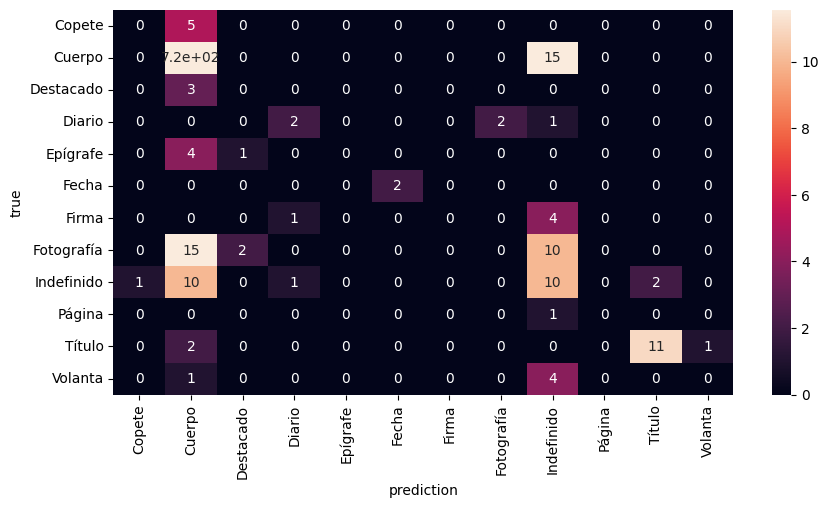

In [30]:
show_metrics(y_true,
    y_pred,
    inv_label_map)

In [31]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      Copete       0.00      0.00      0.00         5
      Cuerpo       0.95      0.98      0.96       737
   Destacado       0.00      0.00      0.00         3
      Diario       0.50      0.40      0.44         5
    Epígrafe       0.00      0.00      0.00         5
       Fecha       1.00      1.00      1.00         2
       Firma       0.00      0.00      0.00         5
  Fotografía       0.00      0.00      0.00        27
  Indefinido       0.22      0.42      0.29        24
      Página       0.00      0.00      0.00         1
      Título       0.85      0.79      0.81        14
     Volanta       0.00      0.00      0.00         5

    accuracy                           0.90       833
   macro avg       0.29      0.30      0.29       833
weighted avg       0.86      0.90      0.88       833

